,band1,band2,band3,band4,band5,band6,band7,land_type
0,12970,12437,12250,12295,9185,7283,6879,1
1,12981,12429,12267,12297,9183,7261,6877,1
2,12908,12401,12234,12268,9169,7243,6859,1
3,12933,12399,12226,12267,9150,7237,6846,1
4,12944,12423,12237,12295,9183,7259,6865,1
...,...,...,...,...,...,...,...,...
232,12451,11743,10697,10885,12441,12047,11204,3
233,12697,12013,11288,11145,13442,12078,10624,3
234,12302,11508,10652,10625,11873,11669,10599,3
235,12138,11280,10448,10570,12356,11627,10629,3


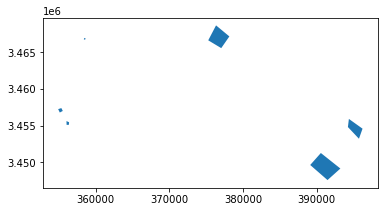

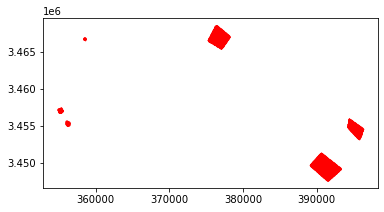

In [1]:
# 引入所需第三方库
from shapely.geometry import Point
from osgeo import gdal
import geopandas as gpd


# 根据空间坐标计算行列坐标
def world2Pixel(geotransform, x, y):
    originX = geotransform[0]
    originY = geotransform[3]
    pixelWidth = geotransform[1]
    pixelHeight = geotransform[5]
    line = int((y-originY)/pixelHeight)+1
    column = int((x-originX)/pixelWidth)+1
    return (line, column)


# 根据行列坐标计算空间坐标
def Pixel2world(geotransform, line, column):
    originX = geotransform[0]
    originY = geotransform[3]
    pixelWidth = geotransform[1]
    pixelHeight = geotransform[5]
    x = column*pixelWidth + originX-pixelWidth/2
    y = line*pixelHeight + originY-pixelHeight/2
    return(x, y)


# 读取 shapefile 和 img 文件
samples = gpd.read_file("./GeoData/sample_regions.shp")
ds = gdal.Open("./GeoData/20180523.img")
geotransform = ds.GetGeoTransform()
projection = ds.GetProjection()
raster = ds.ReadAsArray()
band_label = ["band1", "band2", "band3", "band4", "band5", "band6", "band7"]

# 创建空的 GeoDataFrame，用于保存波段提取结果
train_values = gpd.GeoDataFrame()
# 创建空的列表，用于保存样本区域范围内的栅格格点
pts = []
for a in range(len(samples)):
    sample = samples.iloc[a, :] # 获取样本区域内第 a 个多边形
    minx, miny, maxx, maxy = sample["geometry"].bounds # 获取多边形的外接矩形左下点与右上点坐标
    land_type = sample["Id"]

    LL_line, LL_column = world2Pixel(geotransform, minx, miny) # 计算左下点对应的行列号
    UR_line, UR_column = world2Pixel(geotransform, maxx, maxy) # 计算右上点对应的行列号

    # 对外接矩形内的每一个点进行遍历，查看该点是否在多边形内
    values = []
    for i in range(UR_line, LL_line+1):
        for j in range(LL_column, UR_column+1):
            x, y = Pixel2world(geotransform, i, j) # 行列号转换为坐标值
            point = Point(x, y) # 将坐标值实例化为点对象
            if(point.within(sample["geometry"])): # 判断该点是否在多边形内
                pts.append(point)
                value = raster[0:7, i, j] # 根据格点的行列坐标提取遥感图像1-7波段的栅格值
                values.append(value)

    bands = gpd.GeoDataFrame(values, columns=band_label) # 将所有在多边形内的点提取出的栅格值列表转换为 GeoDataFrame
    bands["land_type"] = land_type # 添加样本区域的Id字段值以表示类别

    train_values = train_values.append(bands) # 将一个样本多边形内的结果追加到保存最终结果的 GeoDataFrame 中

samples.plot() # 显示样本区域多边形
pts_gpd = gpd.GeoDataFrame(pts, columns=["geometry"])
pts_gpd.plot(color='red', markersize=0.5) # 显示样本区域范围内的栅格格点
train_values = train_values.reset_index(drop=True) # 索引重排
train_values # 输出提取结果


In [3]:

train_values

,band1,band2,band3,band4,band5,band6,band7,land_type
0,12970,12437,12250,12295,9185,7283,6879,1
1,12981,12429,12267,12297,9183,7261,6877,1
2,12908,12401,12234,12268,9169,7243,6859,1
3,12933,12399,12226,12267,9150,7237,6846,1
4,12944,12423,12237,12295,9183,7259,6865,1
...,...,...,...,...,...,...,...,...
16466,12451,11743,10697,10885,12441,12047,11204,3
16467,12697,12013,11288,11145,13442,12078,10624,3
16468,12302,11508,10652,10625,11873,11669,10599,3
16469,12138,11280,10448,10570,12356,11627,10629,3
